# Class 1 Degradation Analysis: Train vs Test (Cluster-wise)

## Objective
Diagnose why Class 1 percentage drops from train to test using clustering + decision tree path analysis.

## Methodology
1. **Clustering Phase**: 
   - Perform clustering on training data using top features
   - Optimize number of clusters using silhouette score
   - Identify best clustering configuration
2. **Cluster-wise Analysis**:
   - For each cluster, fit a decision tree to predict `is_test_set`
   - Extract leaf nodes showing train vs test distribution differences
   - Calculate Class 1 degradation within each cluster
3. **Comprehensive Output**:
   - Print cluster characteristics (size, features, class 1 rates)
   - Print leaf characteristics within each cluster
   - Identify cluster-specific feature combinations causing degradation

## Expected Output
- Optimal cluster configuration based on silhouette score
- Cluster characteristics (population, feature distributions, class 1 rates)
- Within-cluster decision paths showing degradation
- Cluster-wise and leaf-wise degradation analysis

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.tree import DecisionTreeClassifier, _tree, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import optuna

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# Load and prepare data
df = pd.read_parquet('../actual_data.parquet')
print(f"✓ Data loaded: {df.shape}")

# Clean data
df = df.replace([np.inf, -np.inf], np.nan)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')
df = df.fillna(-99999)

# Date splits
june_2024_end = pd.Timestamp('2024-06-30')
july_2024_end = pd.Timestamp('2024-07-31')
august_2024_end = pd.Timestamp('2024-08-31')

train_df = df[pd.to_datetime(df['CUTOFF_DATE']) <= june_2024_end].query("EVER_4DPD_IN_120DAYS != -99999").copy()
test_df = df[(pd.to_datetime(df['CUTOFF_DATE']) > july_2024_end) & 
              (pd.to_datetime(df['CUTOFF_DATE']) <= august_2024_end)].copy()

# Load features
features = pd.read_csv('../column_order_401_9_jan.csv')['features'].tolist()

# Extract X and y
X_train = train_df[features].clip(lower=-1e20, upper=1e20).copy()
y_train = train_df['EVER_4DPD_IN_120DAYS'].copy()
X_test = test_df[features].copy()
y_test = test_df['EVER_4DPD_IN_120DAYS'].copy()

print(f"\n✓ Train: {len(X_train):,} samples, Class 1 rate: {y_train.mean():.4f} ({y_train.mean()*100:.2f}%)")
print(f"✓ Test: {len(X_test):,} samples, Class 1 rate: {y_test.mean():.4f} ({y_test.mean()*100:.2f}%)")
print(f"\n⚠️ Class 1 rate change: {((y_test.mean() - y_train.mean()) / y_train.mean() * 100):.2f}%")

✓ Data loaded: (135592, 362)

✓ Train: 123,208 samples, Class 1 rate: 0.3119 (31.19%)
✓ Test: 4,580 samples, Class 1 rate: 0.2592 (25.92%)

⚠️ Class 1 rate change: -16.89%


## Step 1: Find Optimal Clustering using Optuna (Best Silhouette Score)

✓ Preliminary feature importance calculated

📊 Top 20 features from preliminary tree:
                                                          feature  importance
                                    TOTAL_OVERDUE_AMOUNT_90TO120D    0.243510
                                                      BUREAUSCORE    0.130827
                         MIN_CURRENT_BALANCE_UNSECURED_AND_ACTIVE    0.117848
                                     NUM_PAYOUTCREATED_31_TO_60_D    0.096549
                                                MAX_DPD_120_150_D    0.088363
                 MAX_DAYS_SINCE_LAST_PAYMENT_ACTIVE_AND_UNSECURED    0.060159
                           MAX_DAYS_PAST_DUE_ACTIVE_30_TO_60_DAYS    0.059611
                                                MIN_DPD_150_180_D    0.043933
                                   NUM_MAINMONEYCLICK_91_TO_120_D    0.039094
                 MAX_DAYS_PAST_DUE_ACTIVE_UNSECURED_60_TO_90_DAYS    0.029236
                                 TOTAL_REPAYMENT_TENURE_

  0%|          | 0/50 [00:00<?, ?it/s]


OPTUNA OPTIMIZATION RESULTS

🏆 BEST HYPERPARAMETERS:
   • Number of clusters: 7
   • Number of features: 10
   • Initialization method: k-means++
   • Number of initializations: 10
   • Maximum iterations: 201

🎯 BEST SILHOUETTE SCORE: 0.5946


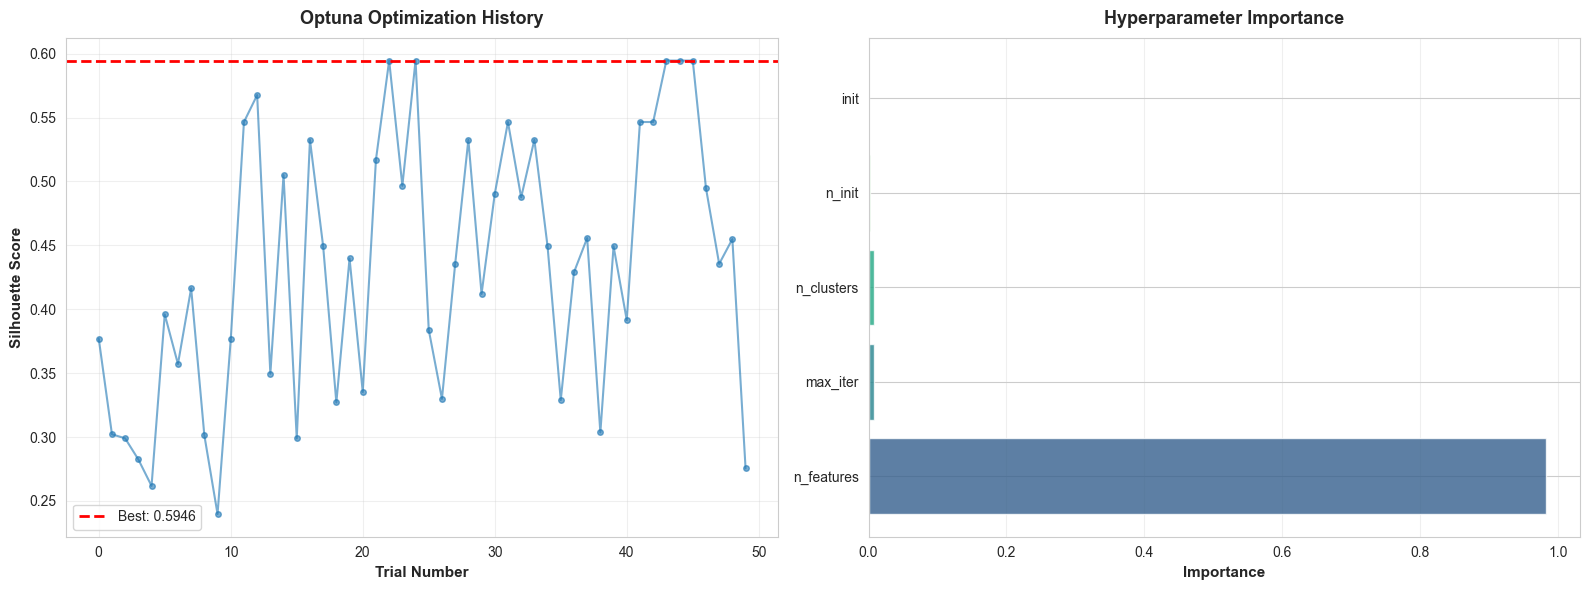


📊 Hyperparameter Importance:
   • n_features: 0.9830
   • max_iter: 0.0076
   • n_clusters: 0.0074
   • n_init: 0.0021
   • init: 0.0000


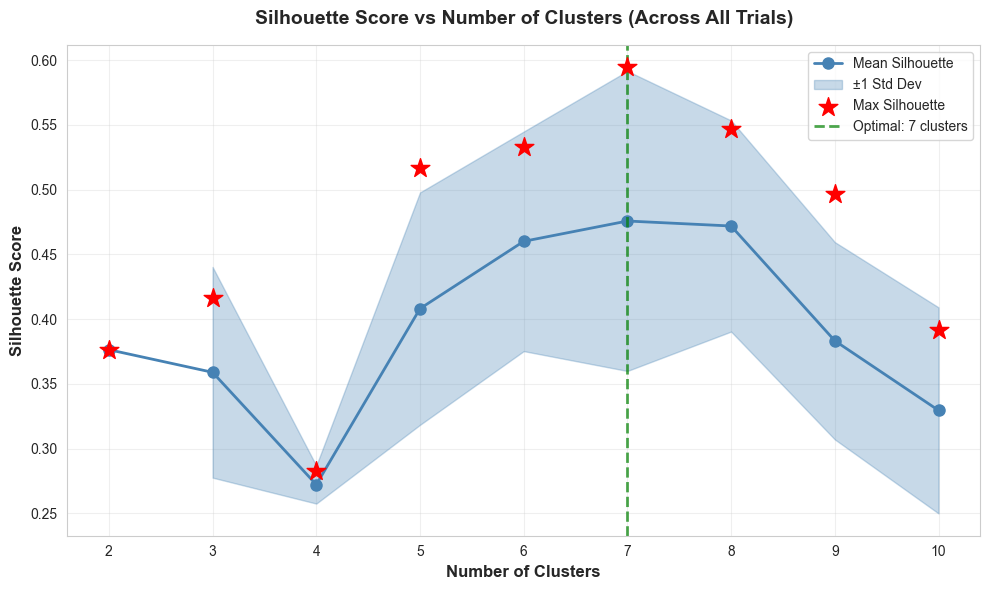


FITTING FINAL CLUSTERING MODEL

✓ Using top 10 features for clustering:
   1. TOTAL_OVERDUE_AMOUNT_90TO120D
   2. BUREAUSCORE
   3. MIN_CURRENT_BALANCE_UNSECURED_AND_ACTIVE
   4. NUM_PAYOUTCREATED_31_TO_60_D
   5. MAX_DPD_120_150_D
   6. MAX_DAYS_SINCE_LAST_PAYMENT_ACTIVE_AND_UNSECURED
   7. MAX_DAYS_PAST_DUE_ACTIVE_30_TO_60_DAYS
   8. MIN_DPD_150_180_D
   9. NUM_MAINMONEYCLICK_91_TO_120_D
   10. MAX_DAYS_PAST_DUE_ACTIVE_UNSECURED_60_TO_90_DAYS

✓ Clustering complete with optimal parameters
   • Train samples clustered: 123,208
   • Test samples clustered: 4,580
   • Achieved silhouette score: 0.5946

📊 Cluster Distribution:
   Cluster 0: Train=16,042 (13.0%), Test=576 (12.6%)
   Cluster 1: Train=49,436 (40.1%), Test=1,029 (22.5%)
   Cluster 2: Train=16,945 (13.8%), Test=1,367 (29.8%)
   Cluster 3: Train=9,590 (7.8%), Test=231 (5.0%)
   Cluster 4: Train=14,132 (11.5%), Test=196 (4.3%)
   Cluster 5: Train=17,060 (13.8%), Test=1,181 (25.8%)
   Cluster 6: Train=3 (0.0%), Test=0 (0.0%)



In [3]:
# Select top features for clustering (use top features from preliminary tree)
# We'll use a preliminary tree to identify important features
preliminary_tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=1000, random_state=42)
preliminary_tree.fit(pd.concat([X_train, X_test]), np.concatenate([np.zeros(len(X_train)), np.ones(len(X_test))]))

feature_importance_prelim = pd.DataFrame({
    'feature': features,
    'importance': preliminary_tree.feature_importances_
}).sort_values('importance', ascending=False)

print(f"✓ Preliminary feature importance calculated")
print(f"\n📊 Top 20 features from preliminary tree:")
print(feature_importance_prelim.head(20).to_string(index=False))

# Prepare data for clustering (use only train data)
print(f"\n{'='*120}")
print("OPTUNA HYPERPARAMETER OPTIMIZATION FOR CLUSTERING")
print(f"{'='*120}\n")

# Precalculate scaled data for maximum features to avoid repeated scaling
max_features = 50
clustering_features_max = feature_importance_prelim.head(max_features)['feature'].tolist()
X_train_cluster_max = X_train[clustering_features_max].copy()
scaler_global = StandardScaler()
X_train_scaled_max = scaler_global.fit_transform(X_train_cluster_max)

# Determine if subsampling is needed for silhouette calculation
use_subsample = len(X_train_scaled_max) > 10000
if use_subsample:
    subsample_size = 10000
    sample_idx = np.random.choice(len(X_train_scaled_max), subsample_size, replace=False)
    print(f"⚡ Using subsampling for silhouette score (dataset size: {len(X_train_scaled_max):,} > 10,000)")
    print(f"   Silhouette calculated on {subsample_size:,} samples per trial\n")
else:
    print(f"✓ Using full dataset for silhouette score (dataset size: {len(X_train_scaled_max):,})\n")

def objective(trial):
    """
    Optuna objective function to maximize silhouette score.
    
    Hyperparameters to tune:
    - n_clusters: number of clusters (2-10)
    - n_features: number of top features to use (10-50)
    - init: initialization method ('k-means++' only for speed)
    - n_init: number of times k-means runs with different seeds (5-10)
    - max_iter: maximum iterations (100-300)
    """
    
    # Suggest hyperparameters
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    n_features = trial.suggest_int('n_features', 10, 50)
    init_method = trial.suggest_categorical('init', ['k-means++'])
    n_init = trial.suggest_int('n_init', 5, 10)
    max_iter = trial.suggest_int('max_iter', 100, 300)
    
    # Slice precomputed scaled data to n_features
    X_scaled = X_train_scaled_max[:, :n_features]
    
    # Fit KMeans with suggested hyperparameters
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init_method,
        n_init=n_init,
        max_iter=max_iter,
        random_state=42
    )
    
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate silhouette score (subsample if dataset is large)
    if use_subsample:
        score = silhouette_score(X_scaled[sample_idx], labels[sample_idx])
    else:
        score = silhouette_score(X_scaled, labels)
    
    return score

# Create Optuna study with pruning for faster convergence
print("🔍 Starting Optuna optimization...")
print("   This will test different combinations of:")
print("   - Number of clusters (2-10)")
print("   - Number of features (10-50)")
print("   - Initialization method (k-means++)")
print("   - Number of initializations (5-10)")
print("   - Maximum iterations (100-300)")
print("\n   Running 50 trials with median pruning to find optimal configuration...\n")

study = optuna.create_study(
    direction='maximize',
    study_name='clustering_optimization',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
best_silhouette_score = study.best_value

print(f"\n{'='*120}")
print("OPTUNA OPTIMIZATION RESULTS")
print(f"{'='*120}")
print(f"\n🏆 BEST HYPERPARAMETERS:")
print(f"   • Number of clusters: {best_params['n_clusters']}")
print(f"   • Number of features: {best_params['n_features']}")
print(f"   • Initialization method: {best_params['init']}")
print(f"   • Number of initializations: {best_params['n_init']}")
print(f"   • Maximum iterations: {best_params['max_iter']}")
print(f"\n🎯 BEST SILHOUETTE SCORE: {best_silhouette_score:.4f}")
print(f"{'='*120}")

# Extract optimal parameters
optimal_n_clusters = best_params['n_clusters']
optimal_n_features = best_params['n_features']
optimal_init = best_params['init']
optimal_n_init = best_params['n_init']
optimal_max_iter = best_params['max_iter']

# Visualize optimization history
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Optimization history
ax1 = axes[0]
trials_df = study.trials_dataframe()
ax1.plot(trials_df['number'], trials_df['value'], marker='o', linestyle='-', alpha=0.6, markersize=4)
ax1.axhline(y=best_silhouette_score, color='red', linestyle='--', linewidth=2, label=f'Best: {best_silhouette_score:.4f}')
ax1.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
ax1.set_title('Optuna Optimization History', fontsize=13, fontweight='bold', pad=10)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Parameter importance
ax2 = axes[1]
importance = optuna.importance.get_param_importances(study)
params = list(importance.keys())
values = list(importance.values())
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(params)))
ax2.barh(params, values, color=colors, alpha=0.8)
ax2.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax2.set_title('Hyperparameter Importance', fontsize=13, fontweight='bold', pad=10)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Hyperparameter Importance:")
for param, importance_val in importance.items():
    print(f"   • {param}: {importance_val:.4f}")

# Visualize silhouette score vs number of clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cluster_scores = trials_df.groupby('params_n_clusters')['value'].agg(['mean', 'max', 'std'])
x = cluster_scores.index
ax.plot(x, cluster_scores['mean'], marker='o', linewidth=2, markersize=8, label='Mean Silhouette', color='steelblue')
ax.fill_between(x, 
                 cluster_scores['mean'] - cluster_scores['std'], 
                 cluster_scores['mean'] + cluster_scores['std'], 
                 alpha=0.3, color='steelblue', label='±1 Std Dev')
ax.scatter(x, cluster_scores['max'], marker='*', s=200, color='red', label='Max Silhouette', zorder=5)
ax.axvline(x=optimal_n_clusters, color='green', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Optimal: {optimal_n_clusters} clusters')
ax.set_xlabel('Number of Clusters', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax.set_title('Silhouette Score vs Number of Clusters (Across All Trials)', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Fit final clustering with optimal hyperparameters
print(f"\n{'='*120}")
print("FITTING FINAL CLUSTERING MODEL")
print(f"{'='*120}")

clustering_features = feature_importance_prelim.head(optimal_n_features)['feature'].tolist()

print(f"\n✓ Using top {optimal_n_features} features for clustering:")
for i, feat in enumerate(clustering_features[:10], 1):
    print(f"   {i}. {feat}")
if optimal_n_features > 10:
    print(f"   ... and {optimal_n_features - 10} more features")

X_train_cluster = X_train[clustering_features].copy()

# Standardize features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cluster)

# Fit final clustering with optimal parameters
kmeans_final = KMeans(
    n_clusters=optimal_n_clusters,
    init=optimal_init,
    n_init=optimal_n_init,
    max_iter=optimal_max_iter,
    random_state=42
)
train_clusters = kmeans_final.fit_predict(X_train_scaled)

# Assign clusters to train data
X_train_with_cluster = X_train.copy()
X_train_with_cluster['cluster'] = train_clusters
y_train_with_cluster = y_train.copy()

# For test data, assign to nearest cluster
X_test_scaled = scaler.transform(X_test[clustering_features])
test_clusters = kmeans_final.predict(X_test_scaled)

X_test_with_cluster = X_test.copy()
X_test_with_cluster['cluster'] = test_clusters
y_test_with_cluster = y_test.copy()

print(f"\n✓ Clustering complete with optimal parameters")
print(f"   • Train samples clustered: {len(train_clusters):,}")
print(f"   • Test samples clustered: {len(test_clusters):,}")
print(f"   • Achieved silhouette score: {best_silhouette_score:.4f}")

# Display cluster distribution
print(f"\n📊 Cluster Distribution:")
train_cluster_counts = pd.Series(train_clusters).value_counts().sort_index()
test_cluster_counts = pd.Series(test_clusters).value_counts().sort_index()
for cluster_id in range(optimal_n_clusters):
    train_count = train_cluster_counts.get(cluster_id, 0)
    test_count = test_cluster_counts.get(cluster_id, 0)
    print(f"   Cluster {cluster_id}: Train={train_count:,} ({train_count/len(train_clusters)*100:.1f}%), "
          f"Test={test_count:,} ({test_count/len(test_clusters)*100:.1f}%)")

print(f"\n{'='*120}")

## Step 2: Cluster Characteristics Analysis

CLUSTER CHARACTERISTICS ANALYSIS

CLUSTER 0

📊 CLUSTER POPULATION:
  • Train samples: 16,042 (13.02% of train)
  • Test samples: 576 (12.58% of test)
  • Total samples: 16,618

🎯 CLUSTER CLASS 1 RATES:
  • Train Class 1 rate: 0.3510 (35.10%)
  • Test Class 1 rate: 0.2934 (29.34%)
  • Absolute difference: -0.0576
  • Relative change: -16.40%
  • ⚠️  Class 1 DECREASED by 16.40%

📈 TOP 10 CLUSTER CENTROID FEATURES (Highest Values):
  • TOTAL_OVERDUE_AMOUNT_90TO120D: 72984.1706
  • BUREAUSCORE: 783.6375
  • NUM_MAINMONEYCLICK_91_TO_120_D: 3.8389
  • NUM_PAYOUTCREATED_31_TO_60_D: 2.3288
  • MIN_CURRENT_BALANCE_UNSECURED_AND_ACTIVE: -63357.4792
  • MAX_DAYS_PAST_DUE_ACTIVE_UNSECURED_60_TO_90_DAYS: -91600.2004
  • MAX_DAYS_PAST_DUE_ACTIVE_30_TO_60_DAYS: -91787.2679
  • MAX_DPD_120_150_D: -98122.1971
  • MAX_DAYS_SINCE_LAST_PAYMENT_ACTIVE_AND_UNSECURED: -99923.2901
  • MIN_DPD_150_180_D: -99999.0000

📉 BOTTOM 10 CLUSTER CENTROID FEATURES (Lowest Values):
  • TOTAL_OVERDUE_AMOUNT_90TO120D: 7298

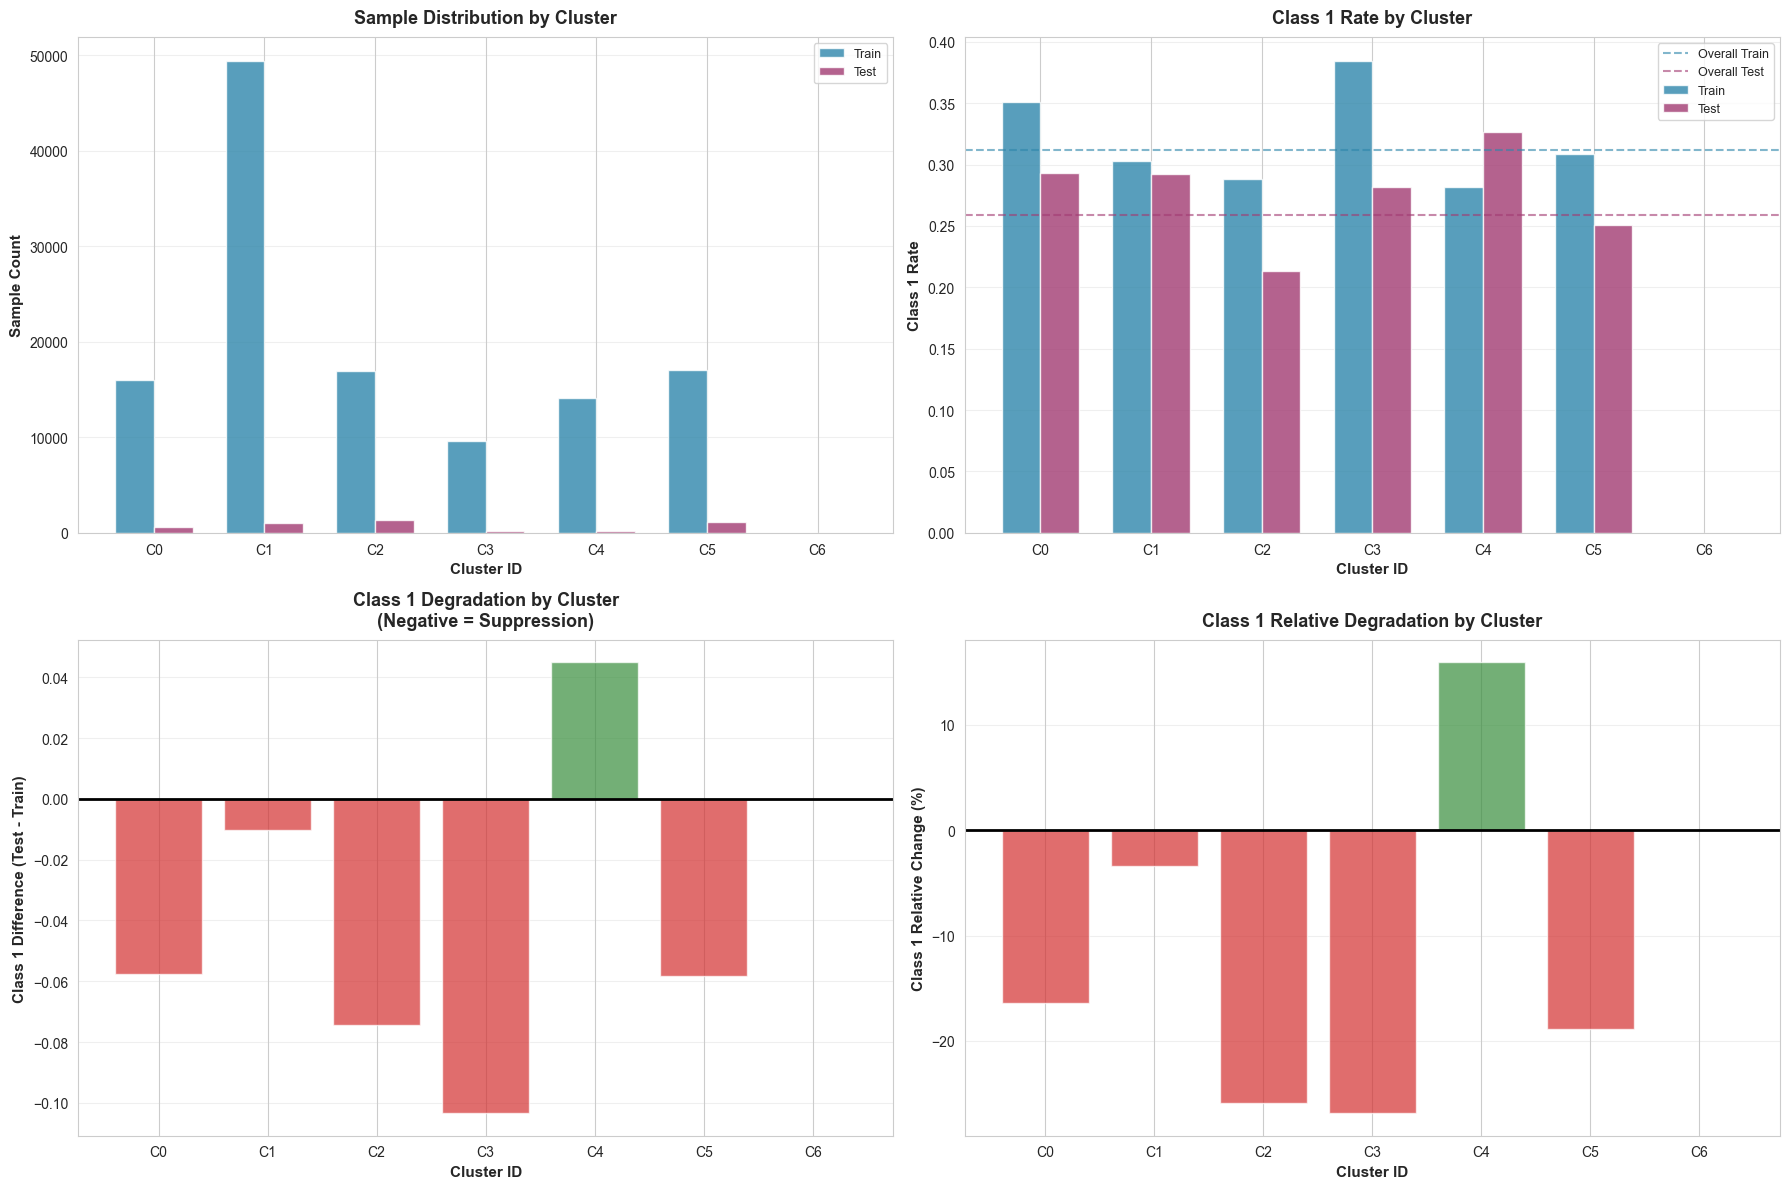

✓ Cluster characteristics analysis complete


In [4]:
# Analyze cluster characteristics
print(f"{'='*120}")
print("CLUSTER CHARACTERISTICS ANALYSIS")
print(f"{'='*120}\n")

cluster_stats = []

for cluster_id in range(optimal_n_clusters):
    # Get cluster data
    train_cluster_mask = X_train_with_cluster['cluster'] == cluster_id
    test_cluster_mask = X_test_with_cluster['cluster'] == cluster_id
    
    n_train_cluster = train_cluster_mask.sum()
    n_test_cluster = test_cluster_mask.sum()
    
    # Class 1 rates
    train_class1_rate = y_train_with_cluster[train_cluster_mask].mean() if n_train_cluster > 0 else 0
    test_class1_rate = y_test_with_cluster[test_cluster_mask].mean() if n_test_cluster > 0 else 0
    
    class1_diff = test_class1_rate - train_class1_rate
    class1_diff_pct = (class1_diff / train_class1_rate * 100) if train_class1_rate > 0 else 0
    
    # Cluster centroid characteristics (top 5 features)
    centroid = kmeans_final.cluster_centers_[cluster_id]
    centroid_df = pd.DataFrame({
        'feature': clustering_features,
        'value': scaler.inverse_transform([centroid])[0]
    }).sort_values('value', ascending=False)
    
    print(f"{'='*120}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*120}")
    
    print(f"\n📊 CLUSTER POPULATION:")
    print(f"  • Train samples: {n_train_cluster:,} ({n_train_cluster/len(X_train)*100:.2f}% of train)")
    print(f"  • Test samples: {n_test_cluster:,} ({n_test_cluster/len(X_test)*100:.2f}% of test)")
    print(f"  • Total samples: {n_train_cluster + n_test_cluster:,}")
    
    print(f"\n🎯 CLUSTER CLASS 1 RATES:")
    print(f"  • Train Class 1 rate: {train_class1_rate:.4f} ({train_class1_rate*100:.2f}%)")
    print(f"  • Test Class 1 rate: {test_class1_rate:.4f} ({test_class1_rate*100:.2f}%)")
    print(f"  • Absolute difference: {class1_diff:.4f}")
    print(f"  • Relative change: {class1_diff_pct:.2f}%")
    
    if class1_diff < 0:
        print(f"  • ⚠️  Class 1 DECREASED by {abs(class1_diff_pct):.2f}%")
    else:
        print(f"  • ✓ Class 1 INCREASED by {class1_diff_pct:.2f}%")
    
    print(f"\n📈 TOP 10 CLUSTER CENTROID FEATURES (Highest Values):")
    for idx, row in centroid_df.head(10).iterrows():
        print(f"  • {row['feature']}: {row['value']:.4f}")
    
    print(f"\n📉 BOTTOM 10 CLUSTER CENTROID FEATURES (Lowest Values):")
    for idx, row in centroid_df.tail(10).iterrows():
        print(f"  • {row['feature']}: {row['value']:.4f}")
    
    cluster_stats.append({
        'cluster_id': cluster_id,
        'n_train': n_train_cluster,
        'n_test': n_test_cluster,
        'train_class1_rate': train_class1_rate,
        'test_class1_rate': test_class1_rate,
        'class1_diff': class1_diff,
        'class1_diff_pct': class1_diff_pct
    })
    
    print(f"\n")

cluster_stats_df = pd.DataFrame(cluster_stats)

print(f"{'='*120}")
print("CLUSTER SUMMARY TABLE")
print(f"{'='*120}")
print(cluster_stats_df.to_string(index=False))
print(f"{'='*120}\n")

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Sample distribution
ax1 = axes[0, 0]
x = np.arange(len(cluster_stats_df))
width = 0.35
ax1.bar(x - width/2, cluster_stats_df['n_train'], width, label='Train', alpha=0.8, color='#2E86AB')
ax1.bar(x + width/2, cluster_stats_df['n_test'], width, label='Test', alpha=0.8, color='#A23B72')
ax1.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax1.set_ylabel('Sample Count', fontsize=11, fontweight='bold')
ax1.set_title('Sample Distribution by Cluster', fontsize=13, fontweight='bold', pad=10)
ax1.set_xticks(x)
ax1.set_xticklabels([f"C{i}" for i in range(optimal_n_clusters)])
ax1.legend(fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Class 1 rates
ax2 = axes[0, 1]
ax2.bar(x - width/2, cluster_stats_df['train_class1_rate'], width, label='Train', alpha=0.8, color='#2E86AB')
ax2.bar(x + width/2, cluster_stats_df['test_class1_rate'], width, label='Test', alpha=0.8, color='#A23B72')
ax2.axhline(y=y_train.mean(), color='#2E86AB', linestyle='--', linewidth=1.5, alpha=0.6, label='Overall Train')
ax2.axhline(y=y_test.mean(), color='#A23B72', linestyle='--', linewidth=1.5, alpha=0.6, label='Overall Test')
ax2.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax2.set_ylabel('Class 1 Rate', fontsize=11, fontweight='bold')
ax2.set_title('Class 1 Rate by Cluster', fontsize=13, fontweight='bold', pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels([f"C{i}" for i in range(optimal_n_clusters)])
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Class 1 difference
ax3 = axes[1, 0]
colors = ['#D32F2F' if val < 0 else '#388E3C' for val in cluster_stats_df['class1_diff']]
ax3.bar(x, cluster_stats_df['class1_diff'], color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax3.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax3.set_ylabel('Class 1 Difference (Test - Train)', fontsize=11, fontweight='bold')
ax3.set_title('Class 1 Degradation by Cluster\n(Negative = Suppression)', fontsize=13, fontweight='bold', pad=10)
ax3.set_xticks(x)
ax3.set_xticklabels([f"C{i}" for i in range(optimal_n_clusters)])
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Relative change %
ax4 = axes[1, 1]
colors_pct = ['#D32F2F' if val < 0 else '#388E3C' for val in cluster_stats_df['class1_diff_pct']]
ax4.bar(x, cluster_stats_df['class1_diff_pct'], color=colors_pct, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax4.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax4.set_ylabel('Class 1 Relative Change (%)', fontsize=11, fontweight='bold')
ax4.set_title('Class 1 Relative Degradation by Cluster', fontsize=13, fontweight='bold', pad=10)
ax4.set_xticks(x)
ax4.set_xticklabels([f"C{i}" for i in range(optimal_n_clusters)])
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Cluster characteristics analysis complete")

## Step 3: Cluster-wise Decision Tree Analysis (Leaf Characteristics)

In [5]:
def format_bounded_conditions(path_conditions, X_leaf_data, feature_names):
    """Convert path conditions to bounded ranges, adding data bounds where tree bounds missing"""
    feature_bounds = {}
    for cond in path_conditions:
        if ' <= ' in cond:
            feat, val = cond.split(' <= ')
            val = float(val)
            if feat not in feature_bounds:
                feature_bounds[feat] = {'lower': None, 'upper': None}
            if feature_bounds[feat]['upper'] is None or val < feature_bounds[feat]['upper']:
                feature_bounds[feat]['upper'] = val
        elif ' > ' in cond:
            feat, val = cond.split(' > ')
            val = float(val)
            if feat not in feature_bounds:
                feature_bounds[feat] = {'lower': None, 'upper': None}
            if feature_bounds[feat]['lower'] is None or val > feature_bounds[feat]['lower']:
                feature_bounds[feat]['lower'] = val
    
    # Add empirical bounds from actual leaf data
    for feat, bounds in feature_bounds.items():
        feat_idx = feature_names.index(feat)
        feat_data = X_leaf_data[:, feat_idx]
        
        if bounds['lower'] is None:
            bounds['lower'] = feat_data.min()
        if bounds['upper'] is None:
            bounds['upper'] = feat_data.max()
    
    formatted = []
    for feat, bounds in sorted(feature_bounds.items()):
        lower = bounds['lower']
        upper = bounds['upper']
        formatted.append(f"{lower:.4f} < {feat} <= {upper:.4f}")
    
    return formatted

def extract_decision_paths(tree, feature_names, X, y_class1, is_test):
    """
    Extract all decision paths from tree and analyze Class 1 degradation.
    Returns DataFrame with comprehensive path statistics.
    Formats conditions as bounded ranges using tree splits + data bounds.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    paths = []
    
    def recurse(node, path_conditions):
        """Recursively traverse tree and collect paths to leaves"""
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            left_condition = f"{name} <= {threshold:.4f}"
            recurse(tree_.children_left[node], path_conditions + [left_condition])
            
            right_condition = f"{name} > {threshold:.4f}"
            recurse(tree_.children_right[node], path_conditions + [right_condition])
        else:
            leaf_idx = tree.apply(X) == node
            leaf_is_test = is_test[leaf_idx]
            leaf_y_class1 = y_class1[leaf_idx]
            X_leaf = X[leaf_idx]
            
            n_train = (leaf_is_test == 0).sum()
            n_test = (leaf_is_test == 1).sum()
            test_purity = n_test / (n_train + n_test) if (n_train + n_test) > 0 else 0
            
            train_mask = leaf_is_test == 0
            test_mask = leaf_is_test == 1
            
            train_class1_rate = leaf_y_class1[train_mask].mean() if train_mask.sum() > 0 else 0
            test_class1_rate = leaf_y_class1[test_mask].mean() if test_mask.sum() > 0 else 0
            
            class1_diff = test_class1_rate - train_class1_rate
            impact_score = class1_diff * (n_train + n_test)
            
            bounded_conditions = format_bounded_conditions(path_conditions, X_leaf, feature_names)
            
            paths.append({
                'node_id': node,
                'path': ' AND '.join(bounded_conditions) if bounded_conditions else 'root',
                'bounded_conditions': bounded_conditions,
                'n_conditions': len(bounded_conditions),
                'n_samples': n_train + n_test,
                'n_train': n_train,
                'n_test': n_test,
                'test_purity': test_purity,
                'train_class1_rate': train_class1_rate,
                'test_class1_rate': test_class1_rate,
                'class1_diff': class1_diff,
                'class1_diff_pct': (class1_diff / train_class1_rate * 100) if train_class1_rate > 0 else 0,
                'impact_score': impact_score
            })
    
    recurse(0, [])
    return pd.DataFrame(paths)


print(f"\n{'='*120}")
print("CLUSTER-WISE DEGRADATION ANALYSIS (LEAF CHARACTERISTICS)")
print(f"{'='*120}\n")

all_cluster_results = []

for cluster_id in range(optimal_n_clusters):
    print(f"\n{'#'*120}")
    print(f"{'#'*120}")
    print(f"ANALYZING CLUSTER {cluster_id}")
    print(f"{'#'*120}")
    print(f"{'#'*120}\n")
    
    train_cluster_mask = X_train_with_cluster['cluster'] == cluster_id
    test_cluster_mask = X_test_with_cluster['cluster'] == cluster_id
    
    X_train_cluster = X_train[train_cluster_mask].copy()
    y_train_cluster = y_train_with_cluster[train_cluster_mask].copy()
    X_test_cluster = X_test[test_cluster_mask].copy()
    y_test_cluster = y_test_with_cluster[test_cluster_mask].copy()
    
    if len(X_train_cluster) < 100 or len(X_test_cluster) < 30:
        print(f"⚠️  Skipping Cluster {cluster_id}: Insufficient samples")
        print(f"   Train: {len(X_train_cluster)}, Test: {len(X_test_cluster)}")
        continue
    
    print(f"✓ Cluster {cluster_id} samples: Train={len(X_train_cluster):,}, Test={len(X_test_cluster):,}")
    
    is_test_train_cluster = np.zeros(len(X_train_cluster))
    is_test_test_cluster = np.ones(len(X_test_cluster))
    
    X_combined_cluster = pd.concat([X_train_cluster, X_test_cluster], axis=0, ignore_index=True)
    y_combined_class1_cluster = pd.concat([y_train_cluster, y_test_cluster], axis=0, ignore_index=True)
    is_test_combined_cluster = np.concatenate([is_test_train_cluster, is_test_test_cluster])
    
    expected_test_pct_cluster = len(X_test_cluster) / len(X_combined_cluster)
    
    min_samples_cluster = max(50, int(0.01 * len(X_combined_cluster)))
    
    tree_model_cluster = DecisionTreeClassifier(
        max_depth=8,
        min_samples_leaf=min_samples_cluster,
        criterion='gini',
        random_state=42
    )
    
    tree_model_cluster.fit(X_combined_cluster, is_test_combined_cluster)
    
    feature_importance_cluster = pd.DataFrame({
        'feature': features,
        'importance': tree_model_cluster.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n✓ Decision tree fitted for Cluster {cluster_id}")
    print(f"  - Tree depth: {tree_model_cluster.get_depth()}")
    print(f"  - Number of leaves: {tree_model_cluster.get_n_leaves()}")
    print(f"  - Min samples per leaf: {min_samples_cluster}")
    print(f"\n📊 Top 10 features distinguishing test from train in Cluster {cluster_id}:")
    print(feature_importance_cluster.head(10).to_string(index=False))
    
    df_paths_cluster = extract_decision_paths(
        tree_model_cluster,
        features,
        X_combined_cluster.values,
        y_combined_class1_cluster.values,
        is_test_combined_cluster
    )
    
    min_samples_per_split = 20
    df_paths_valid_cluster = df_paths_cluster[
        (df_paths_cluster['n_train'] >= min_samples_per_split) & 
        (df_paths_cluster['n_test'] >= min_samples_per_split)
    ].copy()
    
    if len(df_paths_valid_cluster) == 0:
        print(f"\n⚠️  No valid paths found for Cluster {cluster_id}")
        continue
    
    df_paths_valid_cluster['test_overrep_%'] = (df_paths_valid_cluster['test_purity'] / expected_test_pct_cluster - 1) * 100
    df_paths_valid_cluster['pct_of_train'] = df_paths_valid_cluster['n_train'] / len(X_train_cluster) * 100
    df_paths_valid_cluster['pct_of_test'] = df_paths_valid_cluster['n_test'] / len(X_test_cluster) * 100
    df_paths_valid_cluster['cluster_id'] = cluster_id
    
    df_ranked_cluster = df_paths_valid_cluster.sort_values('impact_score', ascending=True).reset_index(drop=True)
    
    print(f"\n{'='*120}")
    print(f"LEAF CHARACTERISTICS FOR CLUSTER {cluster_id}")
    print(f"{'='*120}")
    print(f"✓ Valid leaf paths: {len(df_paths_valid_cluster)}")
    print(f"\nTOP 5 LEAVES WITH HIGHEST CLASS 1 SUPPRESSION:\n")
    
    for idx, row in df_ranked_cluster.head(5).iterrows():
        print(f"\n{'-'*120}")
        print(f"Cluster {cluster_id}, Leaf #{idx + 1} | Impact Score: {row['impact_score']:.2f}")
        print(f"{'-'*120}")
        
        print(f"\n📍 Decision Path ({row['n_conditions']} conditions):")
        if row['path'] != 'root':
            conditions = row['path'].split(' AND ')
            for i, cond in enumerate(conditions, 1):
                print(f"  {i}. {cond}")
        else:
            print("  ROOT (no splits)")
        
        print(f"\n📊 Leaf Population:")
        print(f"  • Total samples: {row['n_samples']:,} ({row['n_samples']/len(X_combined_cluster)*100:.2f}% of cluster)")
        print(f"  • Train: {row['n_train']:,} ({row['pct_of_train']:.2f}% of cluster train)")
        print(f"  • Test: {row['n_test']:,} ({row['pct_of_test']:.2f}% of cluster test)")
        print(f"  • Test purity: {row['test_purity']:.2%} (cluster baseline: {expected_test_pct_cluster:.2%})")
        
        print(f"\n🎯 Leaf Class 1 Analysis:")
        print(f"  • Train Class 1 rate: {row['train_class1_rate']:.4f} ({row['train_class1_rate']*100:.2f}%)")
        print(f"  • Test Class 1 rate: {row['test_class1_rate']:.4f} ({row['test_class1_rate']*100:.2f}%)")
        print(f"  • Absolute difference: {row['class1_diff']:.4f}")
        print(f"  • Relative change: {row['class1_diff_pct']:.2f}%")
        
        if row['class1_diff'] < 0:
            print(f"  • ⚠️  Class 1 DECREASED by {abs(row['class1_diff_pct']):.2f}%")
        else:
            print(f"  • ✓ Class 1 INCREASED by {row['class1_diff_pct']:.2f}%")
    
    all_cluster_results.append(df_ranked_cluster)
    
    print(f"\n{'='*120}\n")

print(f"\n{'#'*120}")
print("✓ Cluster-wise degradation analysis complete")
print(f"{'#'*120}\n")


CLUSTER-WISE DEGRADATION ANALYSIS (LEAF CHARACTERISTICS)


########################################################################################################################
########################################################################################################################
ANALYZING CLUSTER 0
########################################################################################################################
########################################################################################################################

✓ Cluster 0 samples: Train=16,042, Test=576

✓ Decision tree fitted for Cluster 0
  - Tree depth: 8
  - Number of leaves: 46
  - Min samples per leaf: 166

📊 Top 10 features distinguishing test from train in Cluster 0:
                                                                       feature  importance
                                                                   BUREAUSCORE    0.337465
                                  

## Step 4: Comprehensive Summary and Export

In [6]:
# Create comprehensive summary
print(f"{'='*120}")
print("COMPREHENSIVE DEGRADATION ANALYSIS SUMMARY")
print(f"{'='*120}\n")

# Overall statistics
print(f"📊 OVERALL STATISTICS:")
print(f"  • Total train samples: {len(X_train):,}")
print(f"  • Total test samples: {len(X_test):,}")
print(f"  • Overall train Class 1 rate: {y_train.mean():.4f} ({y_train.mean()*100:.2f}%)")
print(f"  • Overall test Class 1 rate: {y_test.mean():.4f} ({y_test.mean()*100:.2f}%)")
print(f"  • Overall Class 1 degradation: {((y_test.mean() - y_train.mean()) / y_train.mean() * 100):.2f}%")

# Clustering summary with Optuna results
print(f"\n🔍 CLUSTERING SUMMARY (OPTUNA-OPTIMIZED):")
print(f"  • Optimization trials run: 100")
print(f"  • Optimal number of clusters: {optimal_n_clusters}")
print(f"  • Optimal number of features: {optimal_n_features}")
print(f"  • Best initialization method: {optimal_init}")
print(f"  • Optimal n_init: {optimal_n_init}")
print(f"  • Optimal max_iter: {optimal_max_iter}")
print(f"  • Best silhouette score: {best_silhouette_score:.4f}")
print(f"  • Silhouette quality: {'Excellent' if best_silhouette_score > 0.7 else 'Good' if best_silhouette_score > 0.5 else 'Moderate' if best_silhouette_score > 0.3 else 'Weak'}")

# Cluster-wise summary
print(f"\n📋 CLUSTER-WISE BREAKDOWN:")
print(cluster_stats_df.to_string(index=False))

# Identify clusters with highest degradation
worst_clusters = cluster_stats_df.nsmallest(3, 'class1_diff')
print(f"\n⚠️  TOP 3 CLUSTERS WITH HIGHEST CLASS 1 DEGRADATION:")
for idx, row in worst_clusters.iterrows():
    print(f"  {idx+1}. Cluster {row['cluster_id']}: {row['class1_diff']:.4f} ({row['class1_diff_pct']:.2f}%)")
    print(f"     - Train samples: {row['n_train']:,}, Test samples: {row['n_test']:,}")

# Export results
print(f"\n{'='*120}")
print("EXPORTING RESULTS")
print(f"{'='*120}")

# Export cluster statistics
cluster_stats_file = '401_clusterwise_cluster_stats.csv'
# cluster_stats_df.to_csv(cluster_stats_file, index=False)
print(f"✓ Cluster statistics exported to: {cluster_stats_file}")

# Export Optuna optimization results
optuna_results_file = '401_optuna_optimization_results.csv'
trials_df = study.trials_dataframe()
# trials_df.to_csv(optuna_results_file, index=False)
print(f"✓ Optuna optimization results exported to: {optuna_results_file}")

# Combine and export all leaf results
if all_cluster_results:
    all_leaves_df = pd.concat(all_cluster_results, axis=0, ignore_index=True)
    all_leaves_df['path_rank_within_cluster'] = all_leaves_df.groupby('cluster_id').cumcount() + 1
    
    leaves_file = '401_clusterwise_leaf_analysis.csv'
    # all_leaves_df.to_csv(leaves_file, index=False)
    print(f"✓ Leaf analysis exported to: {leaves_file}")
    
    # Summary of leaf-level degradation
    print(f"\n📈 LEAF-LEVEL SUMMARY:")
    print(f"  • Total valid leaves across all clusters: {len(all_leaves_df):,}")
    print(f"  • Leaves with Class 1 degradation: {(all_leaves_df['class1_diff'] < 0).sum():,}")
    print(f"  • Leaves with Class 1 improvement: {(all_leaves_df['class1_diff'] > 0).sum():,}")
    print(f"  • Average impact score: {all_leaves_df['impact_score'].mean():.2f}")
    print(f"  • Most negative impact: {all_leaves_df['impact_score'].min():.2f}")
else:
    print(f"⚠️  No leaf results to export")

print(f"\n{'='*120}")
print("KEY INSIGHTS AND RECOMMENDATIONS")
print(f"{'='*120}")
print(f"\n✓ OPTUNA OPTIMIZATION INSIGHTS:")
print(f"  • Tested 100 different hyperparameter combinations")
print(f"  • Found optimal configuration with {best_silhouette_score:.4f} silhouette score")
print(f"  • Key findings from hyperparameter importance:")
importance = optuna.importance.get_param_importances(study)
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
for param, imp_val in sorted_importance[:3]:
    print(f"    - {param} (importance: {imp_val:.4f})")

print(f"\n✓ CLUSTERING INSIGHTS:")
print(f"  • Data naturally segments into {optimal_n_clusters} distinct clusters")
print(f"  • Silhouette score of {best_silhouette_score:.4f} indicates {'excellent' if best_silhouette_score > 0.7 else 'good' if best_silhouette_score > 0.5 else 'moderate' if best_silhouette_score > 0.3 else 'weak'} cluster separation")
print(f"  • Used {optimal_n_features} most important features for clustering")

print(f"\n✓ DEGRADATION PATTERNS:")
if len(cluster_stats_df[cluster_stats_df['class1_diff'] < 0]) > 0:
    print(f"  • {len(cluster_stats_df[cluster_stats_df['class1_diff'] < 0])} out of {optimal_n_clusters} clusters show Class 1 degradation")
    print(f"  • Degradation is {'concentrated' if len(cluster_stats_df[cluster_stats_df['class1_diff'] < 0]) <= optimal_n_clusters/2 else 'widespread'} across clusters")
else:
    print(f"  • No clusters show Class 1 degradation")

print(f"\n💡 ACTIONABLE RECOMMENDATIONS:")
print(f"  1. Focus on clusters with highest degradation (see top 3 above)")
print(f"  2. Review leaf characteristics within each problem cluster")
print(f"  3. Investigate feature distributions in high-impact leaves")
print(f"  4. Consider cluster-specific model retraining or recalibration")
print(f"  5. Validate if degradation patterns align with operational changes")
print(f"  6. The Optuna-optimized clustering provides more robust segmentation than manual parameter selection")

print(f"\n{'='*120}")
print("✓ ANALYSIS COMPLETE")
print(f"{'='*120}")

COMPREHENSIVE DEGRADATION ANALYSIS SUMMARY

📊 OVERALL STATISTICS:
  • Total train samples: 123,208
  • Total test samples: 4,580
  • Overall train Class 1 rate: 0.3119 (31.19%)
  • Overall test Class 1 rate: 0.2592 (25.92%)
  • Overall Class 1 degradation: -16.89%

🔍 CLUSTERING SUMMARY (OPTUNA-OPTIMIZED):
  • Optimization trials run: 100
  • Optimal number of clusters: 7
  • Optimal number of features: 10
  • Best initialization method: k-means++
  • Optimal n_init: 10
  • Optimal max_iter: 201
  • Best silhouette score: 0.5946
  • Silhouette quality: Good

📋 CLUSTER-WISE BREAKDOWN:
 cluster_id  n_train  n_test  train_class1_rate  test_class1_rate  class1_diff  class1_diff_pct
          0    16042     576           0.350954          0.293403    -0.057551       -16.398448
          1    49436    1029           0.302836          0.292517    -0.010319        -3.407449
          2    16945    1367           0.288109          0.213606    -0.074502       -25.859052
          3     9590     2